# Describe merged sequences file

Download the `merged_results` folder as described by `README.md` in this project 
root folder. Then we can apply some statistics to the merged sequences file.

In [1]:
import Bio.SeqIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src import project_directory

let's read the sequences file:

In [2]:
fasta_file = project_directory / "merged_results/export/rep-seqs.fasta/dna-sequences.fasta"

sequences = Bio.SeqIO.index(fasta_file, "fasta")

How many sequences are in the file?

In [3]:
len(sequences)

122988

Let's measure the length of each sequence and plot a histogram of the lengths:

In [4]:
# get the lengths of all sequences
sequence_lengths = [len(record.seq) for record in sequences.values()]

Let's search for outliers in the lengths of the sequences, for example sequences
with lengths 1.5 far from IQR:

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(sequence_lengths, 25)
Q3 = np.percentile(sequence_lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = [length for length in sequence_lengths if length < lower_bound or length > upper_bound]

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

Lower bound for outliers: 374.5
Upper bound for outliers: 450.5


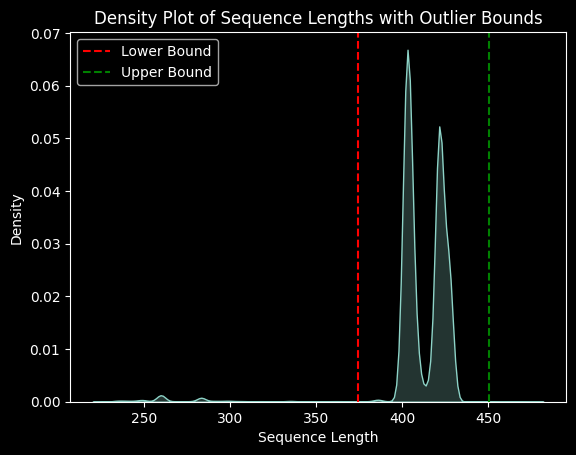

In [6]:
# Create a density plot
sns.kdeplot(sequence_lengths, fill=True)
plt.axvline(lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='--', label='Upper Bound')
plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.title('Density Plot of Sequence Lengths with Outlier Bounds')
plt.legend()
plt.show()

In [7]:
num_below_lower_bound = sum(length < lower_bound for length in sequence_lengths)
print(f"Number of sequences with lengths below the lower bound: {num_below_lower_bound}")

Number of sequences with lengths below the lower bound: 3543
